# Imports

In [16]:
import numpy as np
from scipy.special import comb
import random as rd
import matplotlib.pyplot as plt




# Utility functions

In [17]:
def compute_hypergeometric_prob(N, M, i, k):
    return comb(i,k)*comb(N-i, M-k) / comb(N,M)

def compute_WF_prob(N,i,j,s):
    p = i*(1+s) / (i*(1+s) + N-i)
    if p==0:
        if j==0:
            res = 1
        else:
            res = 0
    elif p==1:
        if j==N:
            res = 1
        else:
            res=0
    else:
        res = comb(N,j) * (p**j) * ((1-p)**(N-j))
    return res

def compute_transition_matrix(N,M,s):
    P = np.zeros((N+1,N+1))
    for i in range(N+1):
        for j in range(N+1):
            coeff = sum([compute_hypergeometric_prob(N,M,i,k) * compute_WF_prob(M,i,k+j-i,s)
                         for k in range(i+1)])
            P[i,j] = coeff
    return P

def draw_from_prob_vector(prob_vector):
    #assert abs(sum(prob_vector) - 1 )< 1e-10
    cumulated_vector = [sum(prob_vector[:k+1]) for k in range(len(prob_vector))]
    x = rd.random()
    i=0
    b = True
    while i < len(prob_vector) and b:
        b = (x > cumulated_vector[i])
        i += 1
    return int(i-1)
    


# Simulating

In [18]:

def simulate_trajectory(N, M, s, tmax, initial_state=1):
    states = [initial_state]
    current_state = initial_state
    t=0
    P = compute_transition_matrix(N,M,s)
    b = True
    while t<tmax and b:
        prob_vector = [P[current_state,j] for j in range(N+1)]
        current_state = draw_from_prob_vector(prob_vector)
        states.append(current_state)
        t += 1
        b = (current_state < N)and(current_state > 0)
        
    fixation = current_state == N
    return states, fixation

N = 10
M = 5
s = 0.1
tmax = 1000

states, fixation = simulate_trajectory(N,M,s,tmax)


(0.0, 10.0)

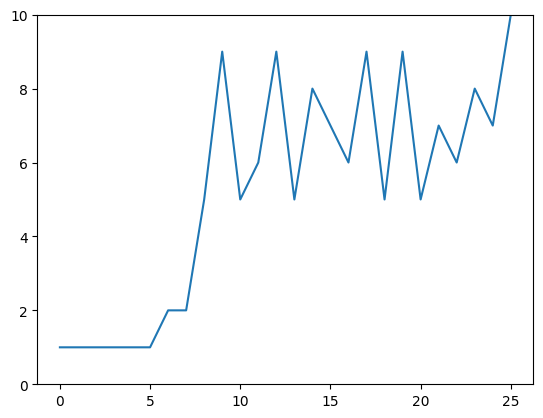

In [19]:
N = 10
M = 5
s = 0.01
tmax = 1000

states, fixation = simulate_trajectory(N,M,s,tmax)

plt.plot(states)
plt.ylim([0,N])


## Max iterations
From "Bridging Wright-Fisher and Moran models", we can derive an approximated time to reach fixation:

we know that $\left\| \pi_t - \pi_\infty \right\|\propto \lambda_*^t$ where $\lambda_* = 1 - \frac{\rho(2-\rho)}{N}$ and $\rho = M/N$

Then having $\left\| \pi_t - \pi_\infty \right\| \approx \varepsilon$ requires $t \approx \frac{\log(\varepsilon)}{\log(\lambda_*)}$


In [20]:
def compute_tmax(N,M, epsilon=1e-5):
    rho = M/N
    lambda_star = 1 - rho * (2-rho) / N
    tmax = np.log(epsilon) / np.log(lambda_star)
    return int(np.ceil(tmax))

compute_tmax(100,100)

1146

## Multiple simulations

In [21]:

def simulate_multiple_trajectories(N, M, s, tmax, nb_trajectories=100, initial_state=1):
    all_trajectories = np.zeros((int(nb_trajectories),int(tmax)))
    all_trajectories[:,0] = initial_state
    P = compute_transition_matrix(N,M,s)

    count_fixation = 0


    for trajectory_index in range(nb_trajectories):
        states = [initial_state]
        current_state = initial_state
        t=1
        b = True
        while t<tmax and b:
            prob_vector = [P[current_state,j] for j in range(N+1)]
            current_state = draw_from_prob_vector(prob_vector)
            states.append(current_state)
            t += 1
            b = (current_state < N)and(current_state > 0)
                
        fixation = current_state == N

        count_fixation += fixation

        if len(states) != tmax:
            if fixation:
                states = states + (tmax-len(states))*[N]
        
        for j in range(len(states)):
            all_trajectories[trajectory_index,j] = states[j]
        

    return all_trajectories, count_fixation

N = 10
M = 5
s = 0.1
tmax = compute_tmax(N,M)

trajectories, count_fixation = simulate_multiple_trajectories(N,M,s,tmax)

77


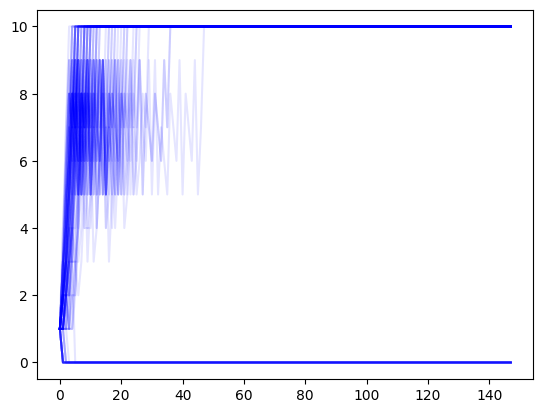

In [22]:
nb_trajectories = trajectories.shape[0]
alpha = 0.1

print(count_fixation)

for i in range(nb_trajectories):
    y = trajectories[i,:]
    plt.plot(y, 'b', alpha= alpha)
plt.show()


## Comparing theoretical and experimental fixation probability

For $N \gg 1$ and $s \approx 1/N$ (Kimura's diffusion approximation),

$\phi (x) = \frac{1-\exp\left(-\frac{2Nsx}{2-\rho}\right))}{1-\exp\left(-\frac{2Ns}{2-\rho}\right))}$

If $x = 1/N$ (starting from one mutant), $s \ll 1$, $N\gg 1$, and $Ns \gg 1$, a simpler approximation for the fixation probability can be obtained:

$\phi _1 = \frac{2s}{2-\rho}$


In [8]:
def phi(N,s,rho,x):
    num = 1 - np.exp(-2*N*s*x / (2-rho))
    denom = 1 - np.exp(-2*N*s / (2-rho))
    return num/denom

def phi_1(s,rho):
    return 2*s/(2-rho)


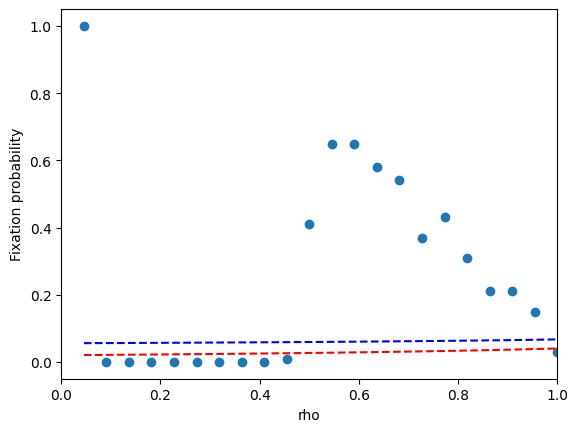

In [28]:
## Varying rho (M)

N = 22 (biggest N with this method)
s = 0.02
tmax = 1000
rhos = []
fixation_freqs = []

for M in range(1,N+1):
    rhos.append(M/N)
    trajectories, count_fixation = simulate_multiple_trajectories(N,M,s,tmax)
    fixation_freq = count_fixation / trajectories.shape[0]
    fixation_freqs.append(fixation_freq)

rhos = np.array(rhos)
plt.scatter(rhos, fixation_freqs)
plt.plot(rhos, [phi(N,s,rho,1/N) for rho in rhos],'b--')
plt.plot(rhos, [phi_1(s,rho) for rho in rhos], 'r--')
plt.xlim([0,1])
plt.xlabel('rho')
plt.ylabel('Fixation probability')
plt.show()

